In [ ]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import glob

In [2]:
chessboardSize = (24,17)
imgSize = (1440,1080)

In [3]:
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

In [4]:
images = glob.glob('media/camera-calibration/*.png')

### Object Points and Image Points 

In [5]:
total_objPoints = []
total_imgPoints = []

In [6]:
objPoints = np.zeros((chessboardSize[0]*chessboardSize[1], 3), np.float32)
objPoints[:, :2] = np.mgrid[:chessboardSize[0], :chessboardSize[1]].T.reshape(-1,2)

In [ ]:
for image in images:
    img = cv.imread(image)
    imgGray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    ret, corners = cv.findChessboardCorners(imgGray, chessboardSize, None)

    if ret:

        total_objPoints.append(objPoints)

        refineCorners = cv.cornerSubPix(imgGray, corners, (11,11), (-1,-1), criteria)

        total_imgPoints.append(refineCorners)


        imgCopy = img.copy()
        cv.drawChessboardCorners(imgCopy, chessboardSize, refineCorners, ret)
        

        imgRGB = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        imgRGBCopy = cv.cvtColor(imgCopy, cv.COLOR_BGR2RGB)

        plt.figure(figsize=(8,6))

        plt.subplot(121)
        plt.imshow(imgRGB)
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(122)
        plt.imshow(imgRGBCopy)
        plt.title('Detected Corners')
        plt.axis('off')

        plt.show()

### Camera Calibration

In [8]:
ret, cameraMatrix, dist, rvecs, tvecs = cv.calibrateCamera(total_objPoints, total_imgPoints, imgSize, None, None)

#### test

In [9]:
print("Camera Matrix's shape: ", cameraMatrix.shape)
print("CameraMatrix': ", cameraMatrix)

# print("Rotation Matrix': ", rvecs)
# print("Transform Matrix': ", tvecs)


print("Distroshion: ", dist)

Camera Matrix's shape:  (3, 3)
CameraMatrix':  [[1.19919013e+03 0.00000000e+00 7.13938547e+02]
 [0.00000000e+00 1.19963621e+03 5.99180946e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distroshion:  [[-2.63853369e-01  2.33014913e-01  6.66105242e-05  4.67529667e-03
  -1.82668262e-01]]


### UnDistrotion

In [10]:
img = cv.imread('media/camera-calibration-distrotion/Image__2018-10-05__10-30-50.png')
height, width = img.shape[:2]

In [11]:
newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, dist, (width,height), 1, (width,height))

distImg = cv.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

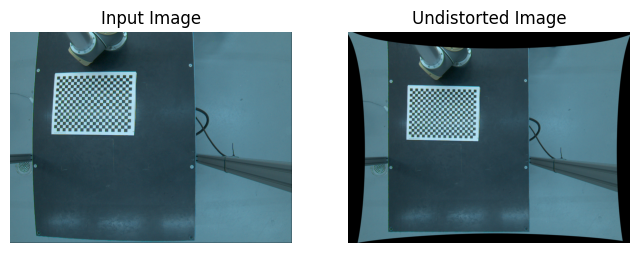

In [12]:
plt.figure(figsize=(8,6))

plt.subplot(121)
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(distImg)
plt.title('Undistorted Image')
plt.axis('off')

plt.show()

#### Crop

(np.float64(-0.5), np.float64(1286.5), np.float64(941.5), np.float64(-0.5))

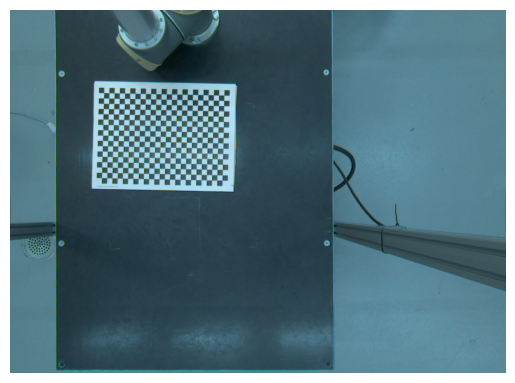

In [13]:
x, y, w, h = roi  # region of interest
distImg = distImg[y:y+h, x:x+w]

plt.figure()
plt.imshow(distImg)
plt.axis('off')

### Undistortion with Remapping

In [ ]:
mapx, mapy = cv.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (width, height), 5)
distMapImg = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

In [15]:
# Crop
x, y, w, h = roi  # region of interest
distMapImg = distMapImg[y:y+h, x:x+w]

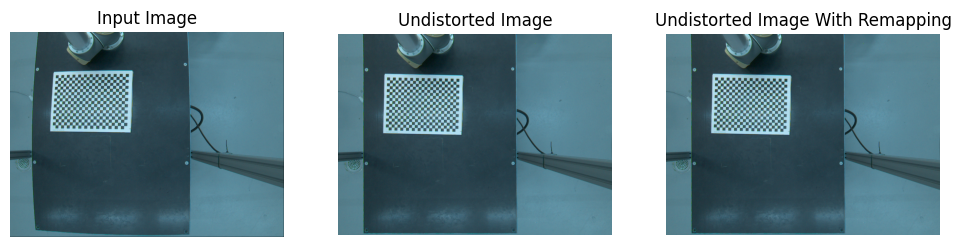

In [16]:
plt.figure(figsize=(12,9))

plt.subplot(131)
plt.imshow(img)
plt.title('Input Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(distImg)
plt.title('Undistorted Image')
plt.axis('off')

plt.subplot(133)
plt.imshow(distMapImg)
plt.title('Undistorted Image With Remapping')
plt.axis('off')

plt.show()

### Compute Reprojection Error

In [17]:
mean_error = 0

for i in range(len(total_objPoints)):
    imgPoints2, _ = cv.projectPoints(total_objPoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
    error = cv.norm(total_imgPoints[i], imgPoints2, cv.NORM_L2)/len(imgPoints2)
    mean_error += error

print( "total error: {}".format(mean_error/len(objPoints)) )

total error: 0.0005660883190215247
